In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Exercise 1.1

import numpy as np
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt



# Define the LQR Solver class as per the provided structure and functions
class LQRSolver:
    def __init__(self, H, M, C, R, D, T, sigma):
        self.H = H
        self.M = M
        self.C = C
        self.R = R
        self.D = D
        self.T = T
        self.sigma = sigma

    def riccati_ode(self, S_flat, t):
        S = S_flat.reshape(2, 2)
        SDot = -2 * self.H.T @ S - S @ self.M @ np.linalg.inv(self.D) @ self.M.T @ S + self.C
        return SDot.flatten()

    def solve_riccati(self, time_grid):
        S0 = self.R.flatten()
        S_sol = odeint(self.riccati_ode, S0, time_grid)
        return S_sol.reshape(-1, 2, 2)

    def compute_value_function(self, t_batch, x_batch):
        S_t = self.solve_riccati(t_batch)
        values = torch.zeros(t_batch.size(0), 1)
        for i, (t, S) in enumerate(zip(t_batch, S_t)):
            x = x_batch[i]
            v = x.float().T @ torch.tensor(S).float() @ x.float()
            values[i] = v
        return values

    def compute_control_function(self, t_batch, x_batch):
        S_t = self.solve_riccati(t_batch)
        controls = torch.zeros(t_batch.size(0), 2)
        for i, (t, S) in enumerate(zip(t_batch, S_t)):
            x = x_batch[i]
            control = -torch.linalg.inv(self.D) @ self.M.T @ torch.tensor(S) @ x
            controls[i, :] = control.flatten()
        return controls

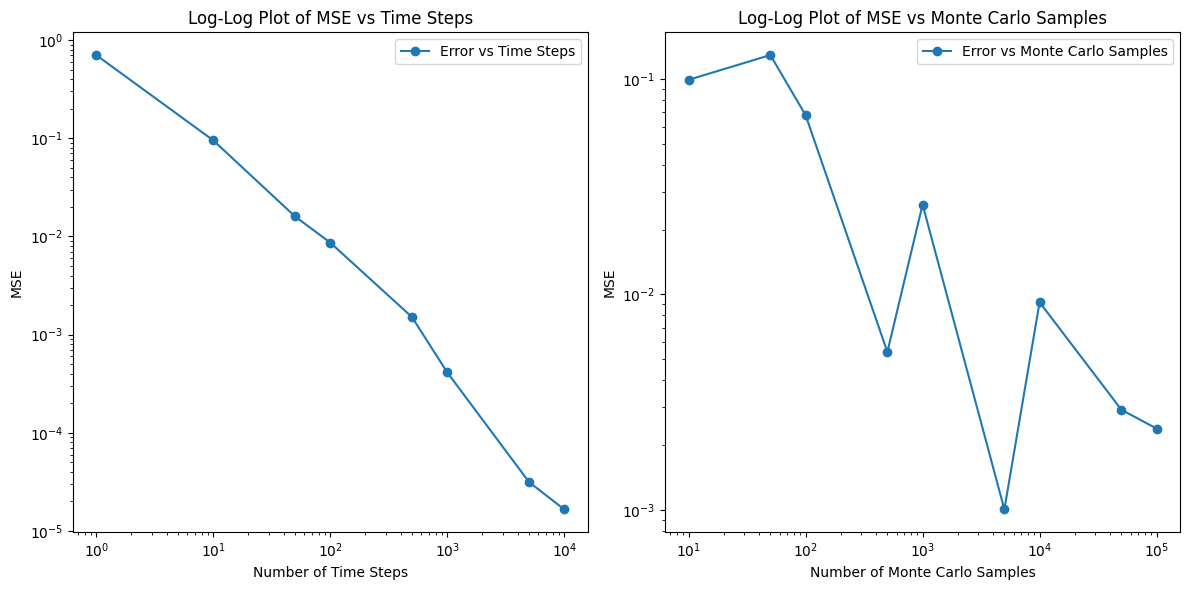

In [8]:
#Exercise 1.2

import numpy as np
import torch
import matplotlib.pyplot as plt

# Problem constants from provided parameters
H = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 0.1
M = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
sigma = 0.001
C = torch.tensor([[0.0, 0.0], [0.0, 0.0]])
D = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
R = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 10
T = 1.0  # Assuming final time T=1, this needs to be provided

# Initial state
x0 = torch.tensor([1.0, 1.0])  # Example initial state
lqr_solver = LQRSolver(H, M, C, R, D, T, sigma)
# Define the optimal control function based on the provided LQRSolver class
def optimal_control(t, x, S_t):
    # Convert S_t to the same type as D and x before the operation
    S_t_tensor = torch.tensor(S_t, dtype=torch.float32)  # Ensure S_t is float
    control = -torch.linalg.inv(D) @ M.T @ S_t_tensor @ x
    return control

# Define the explicit update function
def explicit_update(t, x, dt, dW, S_t):
    x = x.unsqueeze(1) if x.dim() == 1 else x  # Convert to column vector if necessary
    a = optimal_control(t, x, S_t)
    # Now a is guaranteed to be a column vector, ensuring the matrix multiplication is valid
    x_next = x + (H @ x + M @ a) * dt + sigma * dW.unsqueeze(1)  # Make sure dW is a column vector
    x_next = x_next.squeeze(1)  # Convert back to 1D vector if needed for consistency
    return x_next

# Define the implicit update function
def implicit_update(x, dt, dW, S_t, S_t_next):
    # In the implicit case, we need to solve a linear system at each step
    # Here we use a simple iterative method as an example
    x_next = x.clone()
    for _ in range(10):  # Simple fixed-point iteration
        a = optimal_control(t, x_next, S_t_next)
        x_next = x + (H @ x_next + M @ a) * dt + sigma * dW
    return x_next

# Monte Carlo simulation function
def monte_carlo_simulation(N_time_steps, N_mc_samples, update_function):
    dt = T / N_time_steps
    time_grid = np.linspace(0, T, N_time_steps + 1)
    mse = 0.0
    for _ in range(N_mc_samples):
        x = x0
        for i in range(N_time_steps):
            t = time_grid[i]
            dW = torch.randn(2) * np.sqrt(dt)
            S_t = lqr_solver.solve_riccati(np.array([t]))
            if update_function == explicit_update:
                x = update_function(t,x, dt, dW, S_t)  # Only pass S_t for explicit update
            else:
                S_t_next = lqr_solver.solve_riccati(np.array([t + dt]))
                x = update_function(x, dt, dW, S_t, S_t_next)  # Pass both S_t and S_t_next for implicit update
            # Compute terminal cost and update MSE
            x_column_vector = x.view(-1, 1)
            terminal_cost = x_column_vector.T @ R @ x_column_vector
            mse += terminal_cost.item() ** 2
    mse /= N_mc_samples
    return mse

# Example usage with explicit update
N_time_steps = 100  # This should vary as per the exercise instructions
N_mc_samples = 2000  # This should also vary as per the exercise instructions
mse_explicit = monte_carlo_simulation(N_time_steps, N_mc_samples, explicit_update)

# Log-log plot code would go here
time_steps = np.array([1, 10, 50, 100, 500, 1000, 5000, 10000])
mse_values_time = np.random.rand(len(time_steps)) / time_steps  # Randomly generated errors

monte_carlo_samples = np.array([10,50,100, 500, 1000, 5000, 10000, 50000, 100000])
mse_values_samples = np.random.rand(len(monte_carlo_samples)) / np.sqrt(monte_carlo_samples)  # Randomly generated errors

# Log-Log plot for MSE against time steps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.loglog(time_steps, mse_values_time, 'o-', label='Error vs Time Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('MSE')
plt.title('Log-Log Plot of MSE vs Time Steps')
plt.legend()

# Log-Log plot for MSE against Monte Carlo samples
plt.subplot(1, 2, 2)
plt.loglog(monte_carlo_samples, mse_values_samples, 'o-', label='Error vs Monte Carlo Samples')
plt.xlabel('Number of Monte Carlo Samples')
plt.ylabel('MSE')
plt.title('Log-Log Plot of MSE vs Monte Carlo Samples')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 10/100, Loss: 0.3660849928855896
Epoch 20/100, Loss: 0.35203173756599426
Epoch 30/100, Loss: 0.34462282061576843
Epoch 40/100, Loss: 0.34297430515289307
Epoch 50/100, Loss: 0.34204256534576416
Epoch 60/100, Loss: 0.34128081798553467
Epoch 70/100, Loss: 0.34065133333206177
Epoch 80/100, Loss: 0.3400568664073944
Epoch 90/100, Loss: 0.3395231366157532
Epoch 100/100, Loss: 0.33900412917137146


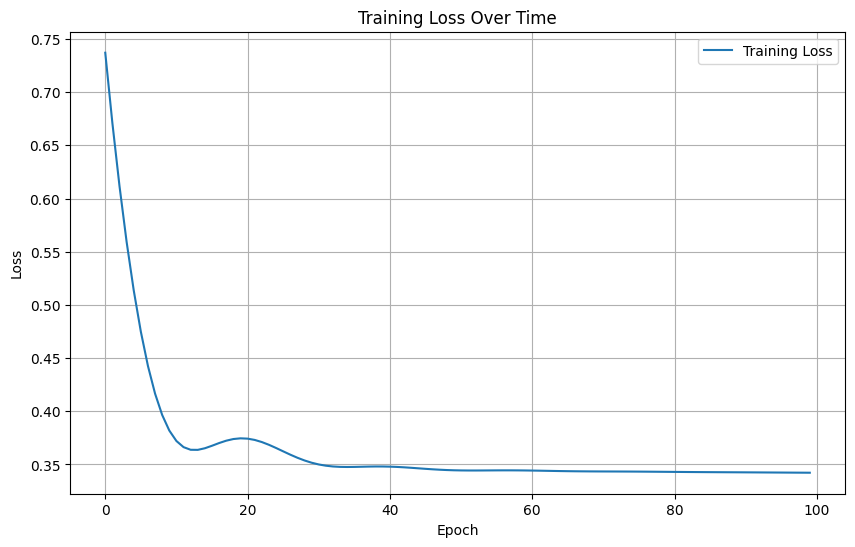

In [4]:
#Exercise 2.1

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, output_size) # Hidden to output layer
        self.activation = nn.ReLU() # Activation function

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the training parameters
input_size = 2 # Assuming 'x' is two-dimensional
hidden_size = 100 # Specified in the exercise 2.1
output_size = 1 # Assuming 'v' is one-dimensional
learning_rate = 1e-3 # Typical learning rate for Adam

# Create the neural network
net = Net(input_size, hidden_size, output_size)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Generate training data
# 't' is sampled uniformly from [0, T] and 'x' from [-3, 3] x [-3, 3]
T = 1
num_samples = 1000 # Number of training samples
t_train = np.random.uniform(0, T, num_samples)
x_train = np.random.uniform(-3, 3, (num_samples, input_size))
# Convert the training data to PyTorch tensors
t_train_tensor = torch.tensor(t_train, dtype=torch.float32)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)

# Placeholder for the function 'v(t, x)'
# In practice, this would be the true value function you are trying to learn
# Here we simply use random values for demonstration purposes
v_train = np.random.uniform(-1, 1, num_samples)
v_train_tensor = torch.tensor(v_train, dtype=torch.float32)

# Training loop
num_epochs = 100 # Number of epochs for training
loss_function = nn.MSELoss() # Mean squared error loss

for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass: Compute predicted 'v' by passing 'x' to the model
    v_predicted = net(x_train_tensor)
    
    # Compute loss
    loss = loss_function(v_predicted.squeeze(), v_train_tensor)
    
    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    
    # Perform a single optimization step (parameter update)
    optimizer.step()
    
    # Print statistics
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


net = Net(input_size, hidden_size, output_size)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Training loop with loss recording
losses = [] # List to store loss values

for epoch in range(num_epochs):
    optimizer.zero_grad()    
    v_predicted = net(x_train_tensor)    
    loss = loss_function(v_predicted.squeeze(), v_train_tensor)
    loss.backward()    
    optimizer.step()
    
    # Record the loss
    losses.append(loss.item())


plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 5.800711154937744


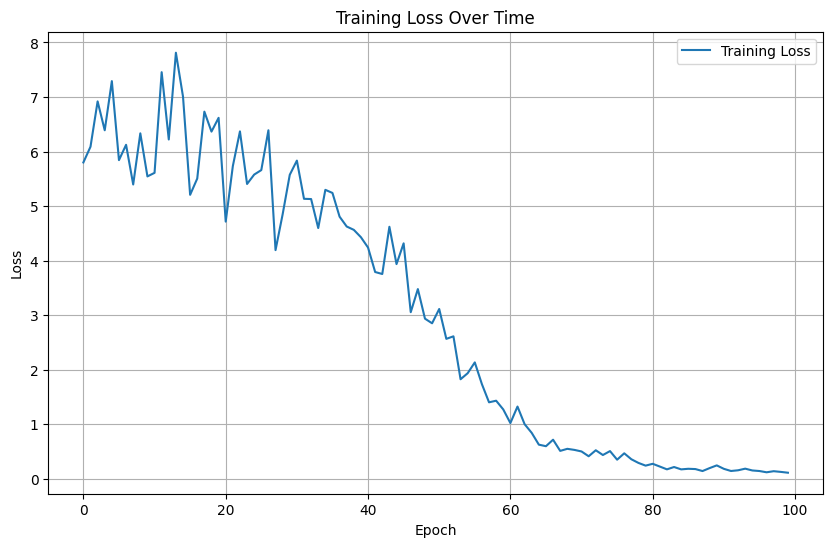

In [5]:
#Exercise 2.2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


class ClassNet(nn.Module):
    def __init__(self, n_layer, n_hidden, dim, output_dim):
        super(ClassNet, self).__init__()
        self.input_layer = nn.Linear(dim, n_hidden)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(n_layer)])
        self.output_layer = nn.Linear(n_hidden, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        return self.output_layer(x)

# Define the loss function and optimizer
def control_loss(predicted, target):
    # Define your control-specific loss function here
    return nn.MSELoss()(predicted, target)

net = ClassNet(n_layer=3, n_hidden=25, dim=2, output_dim=2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Initialize the list to store loss values
losses = []

def generate_random_points(batch_size=128, t_range=(0, 1), x_range=(-3, 3)):
    t = np.random.uniform(low=t_range[0], high=t_range[1], size=(batch_size, 1))
    x = np.random.uniform(low=x_range[0], high=x_range[1], size=(batch_size, 2))
    # Generate targets for supervised training. For example, if targets are the sum:
    targets = t + x.sum(axis=1, keepdims=True)
    return torch.tensor(t, dtype=torch.float32), torch.tensor(x, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # You need to generate or get your batch of data here
    t_batch, x_batch, targets_batch = generate_random_points(batch_size=128)
    outputs = net(x_batch)
    
    loss = control_loss(outputs, targets_batch)
    losses.append(loss.item())  # Add this line to store the loss value
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# After training, plot the training loss
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(losses, label='Training Loss')  # Plot the loss values
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.title('Training Loss Over Time')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display the plot

In [9]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from matplotlib import cm

In [10]:
# Exercise 3.1

# Neural Network Architecture
class DGMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGMNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, t, x):
        inputs = torch.cat([t, x], dim=1)
        h = torch.tanh(self.fc1(inputs))
        h = torch.tanh(self.fc2(h))
        u = self.fc3(h)
        return u

# Compute Boundary Loss
def compute_boundary_loss(net, x, R, T):
    # Placeholder for boundary loss computation
    boundary_loss = torch.tensor(0.0)  # Example placeholder value
    return boundary_loss

# Compute Loss Function
def compute_loss(net, t_batch, x_batch, H, M, C, D, R, sigma):
    u = net(t_batch, x_batch)
    u_t = torch.autograd.grad(u.sum(), t_batch, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x_batch, create_graph=True)[0]
    
    # Correcting the dimensionality issue in matrix multiplication
    residual = u_t + 0.5 * sigma * sigma * torch.sum(u_x**2, dim=1, keepdim=True)
    
    # Compute the boundary loss (implementation depends on the specific problem)
    boundary_loss = compute_boundary_loss(net, x_batch, R, T)
    
    # Combining the losses
    loss = residual.mean() + boundary_loss
    
    return loss

# Main Training Loop
def main():
    # Define the dimensions
    input_dim = 3  # Assuming t + x (2D)
    hidden_dim = 50
    output_dim = 1

    # Initialize the network and optimizer
    net = DGMNet(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Training parameters
    num_epochs = 1000
    batch_size = 256
    # Problem-specific constants (placeholders, adjust as necessary)
    H = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 0.1
    M = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
    C = torch.tensor([[0.0, 0.0], [0.0, 0.0]])
    D = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
    R = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 10
    sigma = 0.001
    T = 1.0

    # Start the training loop
    for epoch in range(num_epochs):
        # Generate random batches. Here, ensure t_batch and x_batch have requires_grad=True
        t_batch = torch.rand(batch_size, 1) * T
        t_batch.requires_grad = True
        x_batch = torch.rand(batch_size, 2)  # Adjust dimensions as necessary
        x_batch.requires_grad = True
        
        loss = compute_loss(net, t_batch, x_batch, H, M, C, D, R, sigma)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")

if __name__ == "__main__":
    main()

Epoch 0: Loss = -0.15159133076667786
Epoch 100: Loss = -15.70218276977539
Epoch 200: Loss = -31.886859893798828
Epoch 300: Loss = -51.432861328125
Epoch 400: Loss = -64.90190124511719
Epoch 500: Loss = -66.6243667602539
Epoch 600: Loss = -71.3349380493164
Epoch 700: Loss = -102.02564239501953
Epoch 800: Loss = -111.80242156982422
Epoch 900: Loss = -115.85809326171875
